Data processing: get a .csv file from *finance.yahoo.com*;
Example stock: https://finance.yahoo.com/quote/NOK/history?p=NOK;
I used 5 year time periods

         Date  Open  High   Low  Close  Adj Close    Volume
0  2020-06-18  5.35  5.72  5.34   5.63       5.63   5619700
1  2020-06-19  6.20  6.25  5.46   5.52       5.52  13137400
2  2020-06-22  5.48  5.48  5.21   5.33       5.33   4412800
3  2020-06-23  5.37  5.40  5.04   5.10       5.10   5699300
4  2020-06-24  4.99  5.12  4.51   4.79       4.79   8104100
training days = (251, 7)


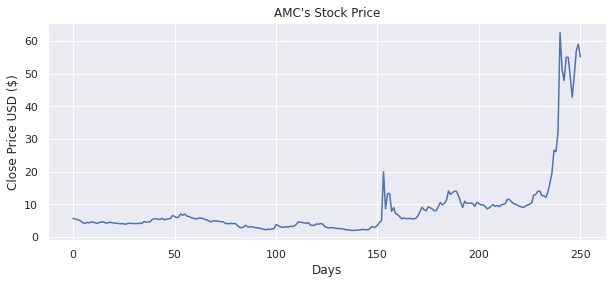

Open         0.982614
High         0.994177
Low          0.984557
Close        1.000000
Adj Close    1.000000
Volume       0.547056
Name: Close, dtype: float64


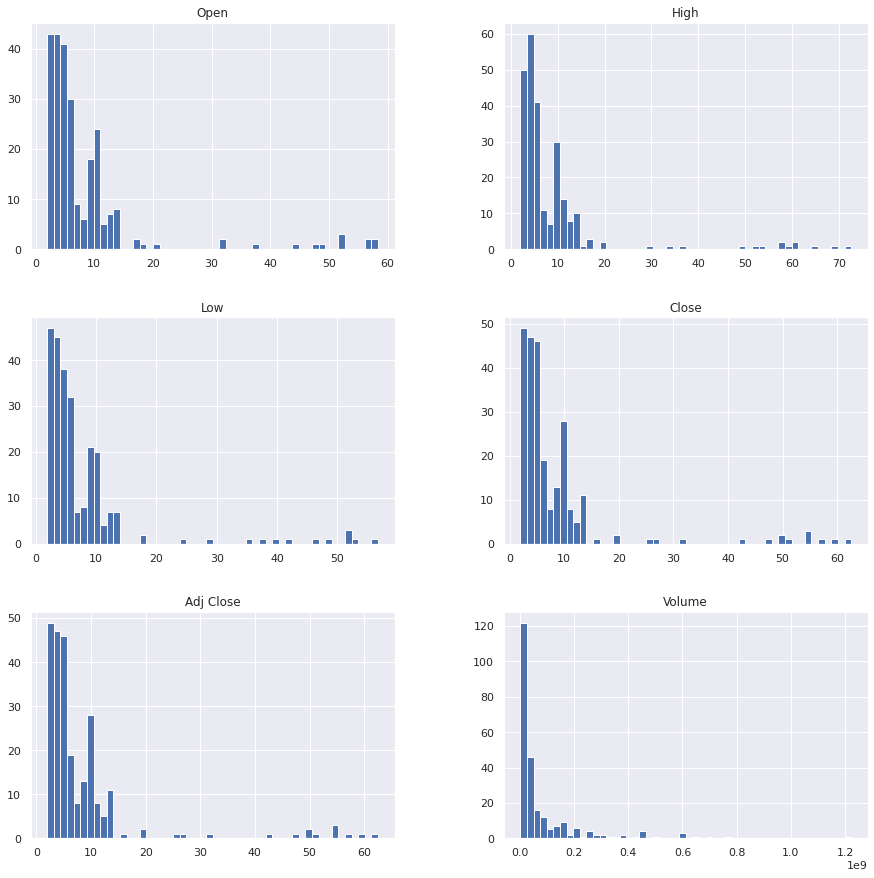

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Upload '.csv' file of any stock and input it here* in this case, we use "AAPL.csv"
df = pd.read_csv("AMC.csv")
print(df.head())
print("training days =",df.shape)


sns.set()
plt.figure(figsize=(10, 4))
plt.title("AMC's Stock Price")
plt.xlabel("Days")
plt.ylabel("Close Price USD ($)")
plt.plot(df["Close"])
plt.show()

#display histogram for six features
df.hist(bins=50,figsize=(15,15))


corr_matrix=df.corr()

print(corr_matrix['Close'])

In [ ]:

df['Date'] = pd.to_datetime(df.Date, format = '%Y-%m-%d')

data = df[['Date', 'Close']].copy()


data['Year'] = ""
data['Month'] = ""
data['Week'] = ""
data['Day'] = ""
data['7DAYS'] = ""
data['5DAYS'] = ""

# Create features from date and create moving averages of 7 & 5 days
for i in range(len(data)):
    data.at[i, 'Year'] = data['Date'][i].year
    data.at[i, 'Month'] = data['Date'][i].month
    data.at[i, 'Week'] = data['Date'][i].week
    data.at[i, 'Day'] = data['Date'][i].day
    if i >= 7:
        seven_avg = 0
        for j in range(1, 8):
            seven_avg += data.at[i-j, 'Close']
        data.at[i, '7DAYS'] = seven_avg/7
    else:
        data.at[i, '7DAYS'] = data.at[i, 'Close']
    if i >= 5:
        five_avg = 0
        for j in range(1, 6):
            five_avg += data.at[i-j, 'Close']
        data.at[i, '5DAYS'] = five_avg/5
    else:
        data.at[i, '5DAYS'] = data.at[i, 'Close']
        
        
# 1000 : 258

x_train = data.drop(['Close', 'Date'], axis = 1)[:250]
y_train = data['Close'][:250]

#Drop moving average from test data because we will need to create new average on every prediction
x_test = data.drop(['Close', 'Date', '7DAYS', '5DAYS'], axis = 1)[200:]
y_test = data['Close'][200:]

x_test = pd.DataFrame(columns = ['Year', 'Month', 'Week', 'Day', '7DAYS', '5DAYS'])

x_test['Index'] = [251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270]
x_test['Year'] = [2021,2021,2021,2021,2021,2021,2021,2021,2021,2021,2021,2021,2021,2021,2021,2021,2021,2021,2021,2021]
x_test['Month'] = [6,6,6,6,6,6,6,6,6,6,7,7,7,7,7,7,7,7,7,7]
x_test['Week'] = [24,24,25,25,25,25,25,26,26,26,26,26,27,27,27,27,27,28,28,28]
x_test['Day'] = [17,18,21,22,23,24,25,28,29,30,1,2,5,6,7,8,9,12,13,14]
x_test['7DAYS'] = ""
x_test['5DAYS'] = ""

x_test = x_test.set_index('Index')

       Year  Month  Week  Day  7DAYS   5DAYS
Index                                       
251    2021      6    24   17  52.52  51.518
       Year  Month  Week  Day                7DAYS                5DAYS
Index                                                                  
252    2021      6    24   18  [51.95828952387385]  [51.86360553342338]
       Year  Month  Week  Day                7DAYS                 5DAYS
Index                                                                   
253    2021      6    25   21  [51.61886103550067]  [53.836405249700945]
       Year  Month  Week  Day                7DAYS                 5DAYS
Index                                                                   
254    2021      6    25   22  [52.82878432576263]  [55.518297456067685]
       Year  Month  Week  Day                 7DAYS                 5DAYS
Index                                                                    
255    2021      6    25   23  [55.304857048327825]  [56.146799

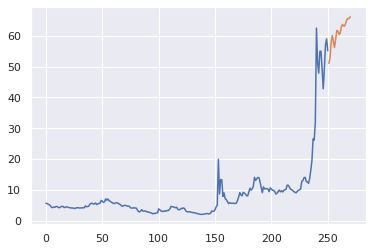

In [ ]:
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
# Linear Regression
linear_model = LinearRegression()
linear_model.fit(x_train, y_train)

#Create moving averages based on past closing prices and predicts price for day
past_closes = data['Close'][len(x_train)-8:len(x_train)].to_list()
for i in range(len(x_test)):
    seven_avg = 0
    five_avg = 0
    for j in range(0, 7):
        seven_avg += past_closes[len(past_closes)-1-j]
    x_test.at[i+251, '7DAYS'] = seven_avg/7
    for j in range(0, 5):
        five_avg += past_closes[len(past_closes)-1-j]
    x_test.at[i+251, '5DAYS'] = five_avg/5
    test = x_test.iloc[[i]]
    #Predict price and add it to the list of past closing prices
    print(test)
    past_closes.append(linear_model.predict(x_test.iloc[[i]]))

#Plot Stock prices with predicted prices on top
plt.plot(df['Close'])
x_test['Predictions'] = past_closes[8:]
plt.plot(x_test['Predictions'])
plt.show()
#Drop the predictions for other models
x_test.drop(['Predictions'], axis = 1, inplace = True)

In [ ]:
from sklearn import metrics
import numpy as np

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, past_closes[8:]))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, past_closes[8:])))
print('R2 Score:', metrics.r2_score(y_test, past_closes[8:]))

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
import numpy as np
# KNN
rmse = []
#find best rmse
for i in range(1, 30):
    knn_model = KNeighborsRegressor(n_neighbors = i)
    knn_model.fit(x_train, y_train)
    knn_preds = knn_model.predict(x_train)
    rmse.append(np.sqrt(np.mean(np.power((np.array(y_train)-np.array(knn_preds)),2))))
print(rmse)

[0.0, 17.79994913186504, 20.865791373959514, 22.835366865151705, 24.55917271726771, 26.941940252768486, 27.517610464923905, 28.043187287480407, 28.587103674829862, 28.965683774312236, 29.593531630219157, 29.822740088265423, 29.924552367955936, 30.11867027330693, 30.32378998277545, 30.425128462897515, 30.521619667745544, 30.965956186976133, 31.362827835387765, 31.231631530149407, 31.50555042832702, 31.56029950462593, 31.64792139242058, 31.912685247748968, 32.214484016441, 32.26753163723592, 32.346332014051534, 32.44010005321271, 32.58731256767607]


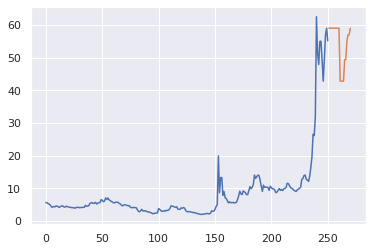

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
#k = 1 where rmse was found to be: 0.097
knn_model = KNeighborsRegressor(n_neighbors = 1)
knn_model.fit(x_train, y_train)

#Create moving averages based on past closing prices
past_closes = data['Close'][len(x_train)-8:len(x_train)].to_list()
for i in range(len(x_test)):
    seven_avg = 0
    five_avg = 0
    for j in range(0, 7):
        seven_avg += past_closes[len(past_closes)-1-j]
    x_test.at[i+251, '7DAYS'] = seven_avg/7
    for j in range(0, 5):
        five_avg += past_closes[len(past_closes)-1-j]
    x_test.at[i+251, '5DAYS'] = five_avg/5
    test = x_test.iloc[[i]]
    #Predict price and add it to the list of past closing prices
    past_closes.append(knn_model.predict(x_test.iloc[[i]]))

#Plot Stock prices with predicted prices on top
plt.plot(df['Close'])
x_test['Predictions'] = past_closes[8:]
plt.plot(x_test['Predictions'])
plt.show()
#Drop the predictions for other models
x_test.drop(['Predictions'], axis = 1, inplace = True)

In [ ]:
from sklearn import metrics

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, past_closes[8:]))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, past_closes[8:])))
print('R2 Score:', metrics.r2_score(y_test, past_closes[8:]))

Mean Absolute Error: 12.134313784313724
Root Mean Squared Error: 21.630187296089737
R2 Score: -0.512386885555496


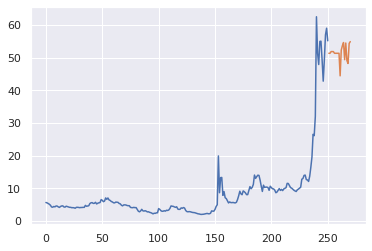

In [ ]:
from sklearn.ensemble import RandomForestRegressor
#Random Forest
# Instantiate model with 64 decision trees
rf = RandomForestRegressor(n_estimators = 64)
# Train the model on training data
rf.fit(x_train, y_train);

#Create moving averages based on past closing prices
past_closes = data['Close'][len(x_train)-8:len(x_train)].to_list()
for i in range(len(x_test)):
    seven_avg = 0
    five_avg = 0
    for j in range(0, 7):
        seven_avg += past_closes[len(past_closes)-1-j]
    x_test.at[i+251, '7DAYS'] = seven_avg/7
    for j in range(0, 5):
        five_avg += past_closes[len(past_closes)-1-j]
    x_test.at[i+251, '5DAYS'] = five_avg/5
    test = x_test.iloc[[i]]
    #Predict price and add it to the list of past closing prices
    past_closes.append(rf.predict(x_test.iloc[[i]]))

#Plot Stock prices with predicted prices on top
plt.plot(df['Close'])
x_test['Predictions'] = past_closes[8:]
plt.plot(x_test['Predictions'])
plt.show()
#Drop the predictions for other models
x_test.drop(['Predictions'], axis = 1, inplace = True)


In [ ]:
from sklearn import metrics

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, past_closes[8:]))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, past_closes[8:])))
print('R2 Score:', metrics.r2_score(y_test, past_closes[8:]))


Mean Absolute Error: 11.370530083333332
Root Mean Squared Error: 20.52617052773322
R2 Score: -0.36194072992786963
